In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error

In [2]:
# 2. Đọc file dữ liệu
btc = pd.read_csv('./Cryptocurrencies/BTC.csv')
eth = pd.read_csv('./Cryptocurrencies/ETH.csv')
doge = pd.read_csv('./Cryptocurrencies/DOGE.csv')

In [3]:
for df in [btc, eth, doge]:
    df['Date'] = pd.to_datetime(df.Date)
    df.set_index('Date', inplace=True)
    df = df[['Close']]

In [4]:
# Tỉ lệ pha train, test
train_ratio = 0.9
test_ratio = 1.0 - train_ratio

In [5]:
# Split the data into training, testing, and validation sets
# BTC
train_size = int(train_ratio * len(btc))
test_size = int(test_ratio * len(btc))
btc_train_data = btc[:train_size]
btc_test_data = btc[train_size:train_size+test_size]

# ETH
train_size = int(train_ratio * len(eth))
test_size = int(test_ratio * len(eth))
eth_train_data = eth[:train_size]
eth_test_data = eth[train_size:train_size+test_size]

# DOGE
train_size = int(train_ratio * len(doge))
test_size = int(test_ratio * len(doge))
doge_train_data = doge[:train_size]
doge_test_data = doge[train_size:train_size+test_size]

In [1]:
!pip install pmdarima

In [6]:
# 3. Quá trình Training
btc_x_train = np.array(btc_train_data.index).reshape(-1, 1)
btc_y_train = np.array(btc_train_data['Close'])

eth_x_train = np.array(eth_train_data.index).reshape(-1, 1)
eth_y_train = np.array(eth_train_data['Close'])

doge_x_train = np.array(doge_train_data.index).reshape(-1, 1)
doge_y_train = np.array(doge_train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
btc_model = auto_arima(btc_y_train, trace=True, error_action='ignore', suppress_warnings=True)
eth_model = auto_arima(eth_y_train, trace=True, error_action='ignore', suppress_warnings=True)
doge_model = auto_arima(doge_y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
btc_model.fit(btc_y_train)
eth_model.fit(eth_y_train)
doge_model.fit(doge_y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=29989.369, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=29989.979, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=29989.995, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29987.969, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=29991.979, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.792 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10815.561, Time=3.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10703.666, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10718.483, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10715.931, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10705.643, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-10740.838, Time=1.58 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept

ARIMA(order=(4, 1, 4), scoring_args={}, suppress_warnings=True)

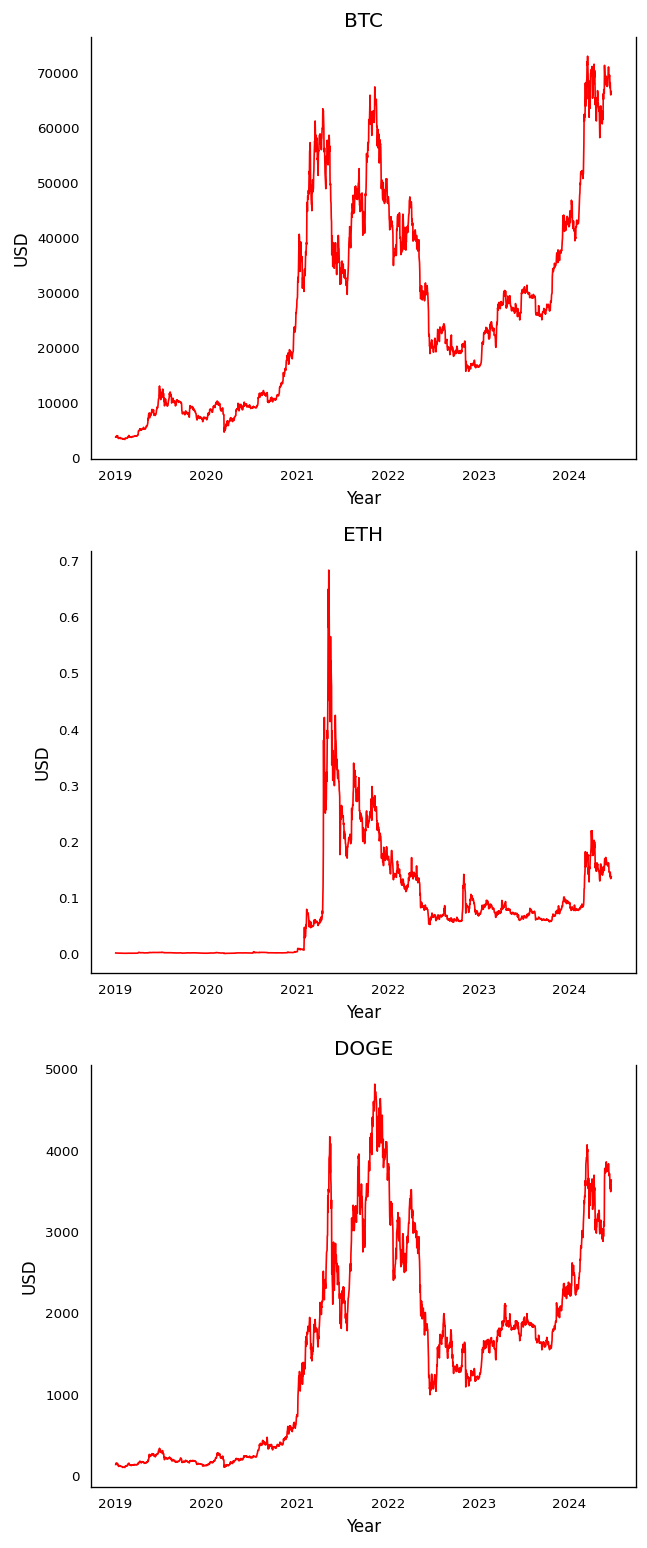

In [7]:
# Plot
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(5.5, 13))

df_list = ['btc', 'eth', 'doge']
coins = ['BTC', 'ETH', 'DOGE']

for i, ax in enumerate(axes.flatten()):
    data = eval(df_list[i])['Close']  # Use iloc for column access, should be fast
    ax.plot(data, color='red', linewidth=1)
    
    # Decorations
    ax.set_title(coins[i])
    ax.set_xlabel('Year')
    ax.set_ylabel('USD')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

In [8]:
# 4. Quá trình testing 
# BTC
btc_x_test = np.array(btc_test_data.index).reshape(-1, 1)
btc_y_test = np.array(btc_test_data['Close'])
btc_y_pred = btc_model.predict(n_periods=len(btc_y_test))

# ETH
eth_x_test = np.array(eth_test_data.index).reshape(-1, 1)
eth_y_test = np.array(eth_test_data['Close'])
eth_y_pred = eth_model.predict(n_periods=len(eth_y_test))

# DOGE
doge_x_test = np.array(doge_test_data.index).reshape(-1, 1)
doge_y_test = np.array(doge_test_data['Close'])
doge_y_pred = doge_model.predict(n_periods=len(doge_y_test))

In [9]:
# 5. Quá trình tạo index predict 30, 60 và 90 ngày tiếp theo
i = 0

for df in df_list:
    days = [30, 60, 90]

    for d in days:
        last_index = len(eval(df))
        last_data = pd.RangeIndex(
            start=last_index, stop=last_index+d, step=1)
        
        globals()[f'{df}_last_{d}_data'] = last_data
        print(eval(f'{df}_last_{d}_data'))
        
        print(f'Current coin: {coins[i]}')
        print(f'Current last index: {last_index} days')
        print(last_data)

        # Create an array of n consecutive integers starting from last_index
        x_next_n_days = np.array(range(last_index, last_index + d)).reshape(-1, 1)

        # Predict the closing prices for the next n days
        globals()[f'{df}_y_next_{d}_days'] = eval(f'{df}_model').predict(n_periods=len(x_next_n_days))

        # Print the predicted closing prices for the next n days
        print(f'Predicted {coins[i]} prices for the next {d} days:')
        print(eval(f'{df}_y_next_{d}_days'))
        print('\n')

    i += 1

RangeIndex(start=1994, stop=2024, step=1)
Current coin: BTC
Current last index: 1994 days
RangeIndex(start=1994, stop=2024, step=1)
Predicted BTC prices for the next 30 days:
[37808.01 37808.01 37808.01 37808.01 37808.01 37808.01 37808.01 37808.01
 37808.01 37808.01 37808.01 37808.01 37808.01 37808.01 37808.01 37808.01
 37808.01 37808.01 37808.01 37808.01 37808.01 37808.01 37808.01 37808.01
 37808.01 37808.01 37808.01 37808.01 37808.01 37808.01]


RangeIndex(start=1994, stop=2054, step=1)
Current coin: BTC
Current last index: 1994 days
RangeIndex(start=1994, stop=2054, step=1)
Predicted BTC prices for the next 60 days:
[37808.01 37808.01 37808.01 37808.01 37808.01 37808.01 37808.01 37808.01
 37808.01 37808.01 37808.01 37808.01 37808.01 37808.01 37808.01 37808.01
 37808.01 37808.01 37808.01 37808.01 37808.01 37808.01 37808.01 37808.01
 37808.01 37808.01 37808.01 37808.01 37808.01 37808.01 37808.01 37808.01
 37808.01 37808.01 37808.01 37808.01 37808.01 37808.01 37808.01 37808.01
 37808.0

In [10]:
# 6. Đánh giá độ chính xác test bằng MAPE, MASE và RMSE
# mase = np.mean([abs(y_test - y_pred) / (abs(Actual[i] - Actual[i - 1]) / len(Actual) - 1) for i in range(1, len(Actual))])
# mape = np.mean(np.abs(btc_y_pred - btc_y_test)/np.abs(btc_y_test))

def mean_absolute_scaled_error(y_test, y_pred):
    # Calculate the mean absolute error of the predictions
    mae_pred = np.mean(np.abs(y_test - y_pred))
    
    # Calculate the mean absolute error of a naive forecast
    mae_naive = np.mean(np.abs(y_test[1:] - y_test[:-1]))
    
    # Calculate MASE
    mase = mae_pred / mae_naive
    
    return mase


for df in df_list:
    mase = mean_absolute_scaled_error(eval(f'{df}_y_test'), eval(f'{df}_y_pred'))
    mape = mean_absolute_percentage_error(eval(f'{df}_y_test'), eval(f'{df}_y_pred'))
    rmse = root_mean_squared_error(eval(f'{df}_y_test'), eval(f'{df}_y_pred'))

    print(df.upper())
    print('MAPE:', mape)
    print('MASE:', mase)
    print('RMSE:', rmse, '\n')


BTC
MAPE: 0.30143975386484234
MASE: 15.898579660822282
RMSE: 22038.089919529742 

ETH
MAPE: 0.2949167002139688
MASE: 8.839119548122785
RMSE: 0.06057652388015268 

DOGE
MAPE: 0.28760123533611087
MASE: 13.874041419947423
RMSE: 1097.8511952531262 



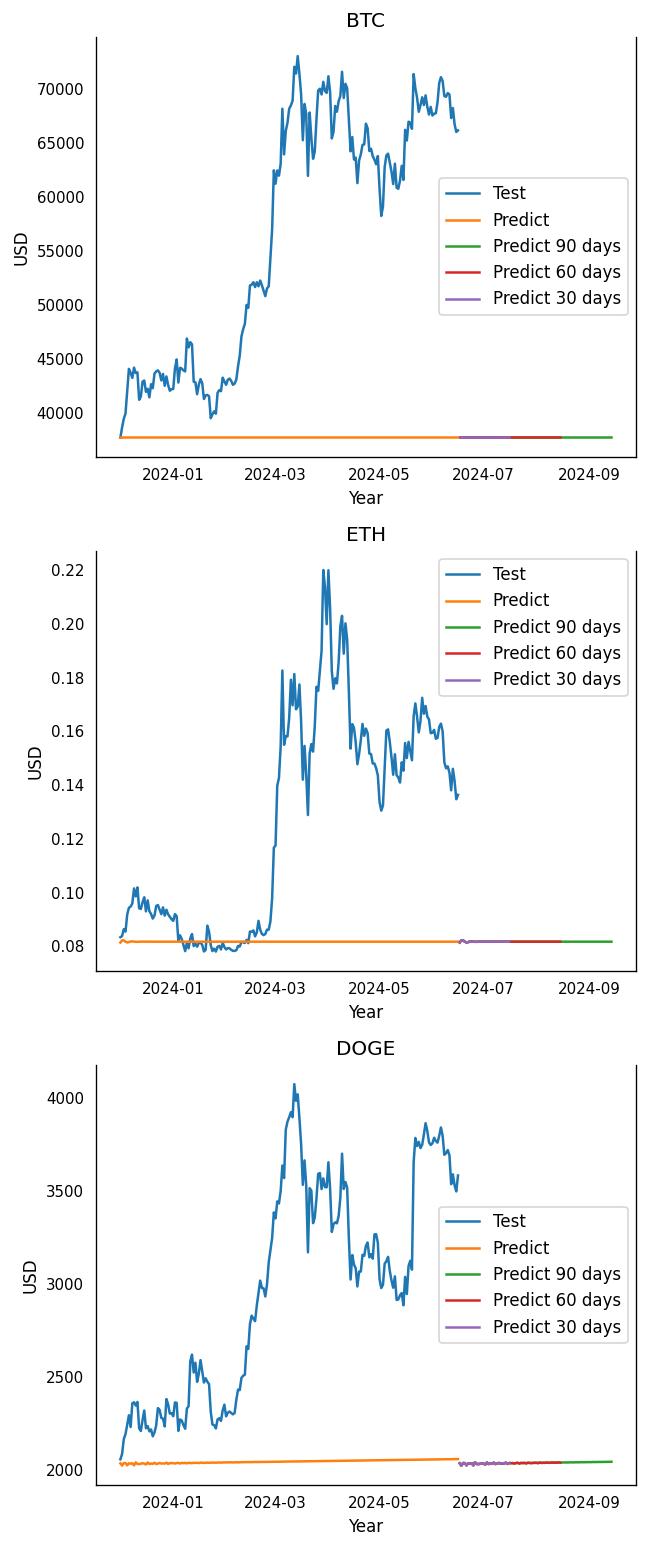

In [12]:
# 7. Vẽ hình
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(5.5, 13))

for i, ax in enumerate(axes.flatten()):
    train_data = eval(f'{df_list[i]}_train_data')
    test_data = eval(f'{df_list[i]}_test_data')
    y_pred = eval(f'{df_list[i]}_y_pred')

    y_next_30_days = eval(f'{df_list[i]}_y_next_30_days')
    y_next_60_days = eval(f'{df_list[i]}_y_next_60_days')
    y_next_90_days = eval(f'{df_list[i]}_y_next_90_days')
    
    last_date = test_data.index[-1]
    last_30_data = pd.date_range(start=last_date, periods=31, inclusive='right')
    last_60_data = pd.date_range(start=last_date, periods=61, inclusive='right')
    last_90_data = pd.date_range(start=last_date, periods=91, inclusive='right')

    # ax.plot(train_data.index, train_data['Close'])
    ax.plot(test_data.index, test_data['Close'])
    ax.plot(test_data.index, y_pred)
    ax.plot(last_90_data, y_next_90_days)
    ax.plot(last_60_data, y_next_60_days)
    ax.plot(last_30_data, y_next_30_days)

    # ax.legend(['Train', 'Test', 'Predict', 'Predict30days', 'Predict60days', 'Predict90days'])
    ax.legend(['Test', 'Predict', 'Predict 90 days', 'Predict 60 days', 'Predict 30 days'])

    # Decorations
    ax.set_title(coins[i])
    ax.set_xlabel('Year')
    ax.set_ylabel('USD')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=9)

    # Format x-axis to show only the year
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=8))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

In [13]:
test_data.index

RangeIndex(start=1116, stop=1435, step=1)